In [81]:
from numpy import hstack, ones, array, mat, tile, reshape, squeeze, eye, asmatrix
from numpy.linalg import inv
from pandas import read_csv, Series
from scipy.linalg import kron
from scipy.optimize import fmin_bfgs
from scipy.ndimage import shift
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [82]:
#Loading of the data and reshuffling in 3 columes : consumption growth, 1-year risk free yield, S&P real return
data =pd.read_csv('data.csv')
data=data.rename(columns={"real_SP_return":"rt",
                    "real_pc_consumption":"ct",
                    "Real_1yr":"1+rf"})
data['ct+1/ct']=data['ct']/data['ct'].shift(1)
data['R0_t+1']=(data['1+rf'])
data['R1_t+1']=(data['rt']+1)
data.set_index("year", inplace=True)
data=data.loc[:,data.columns[-3:]].dropna()
data

,ct+1/ct,R0_t+1,R1_t+1
year,,,
1928,1.010128,1.058639,1.483782
1929,1.043471,1.060100,0.912309
1930,0.936541,1.120104,0.840166
1931,0.961819,1.138907,0.634569
1932,0.905437,1.145774,1.013701
...,...,...,...
2005,1.024169,0.994467,1.058980
2006,1.019273,1.031784,1.110144
2007,1.016571,1.009684,0.946607


<AxesSubplot:xlabel='year'>

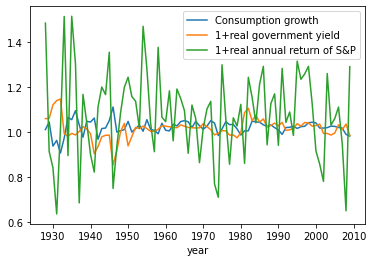

In [83]:
graph=data.rename(columns={"ct+1/ct":"Consumption growth",
                    "R0_t+1":"1+real government yield",
                           "R1_t+1":"1+real annual return of S&P"})
graph.plot()

In [84]:
 #Infer the number of observations and the number of assets from the dimensions of the dataset, and define the number of lags used in the creation of instrumental variables
l= 2
N=data.shape[1] - 1 #Number of assets 
T=data.shape[0] #Size of the dataset
N, T

(2, 82)

In [85]:
 #Define the moment conditions h_t for every time t: There will be 1 + l*(N+1)instrument variables and N*(1+l*(N+1)) moment conditions
def h_t(t,params,l): 
    X=data.iloc[t].to_numpy() 
    delta=params[0]
    alpha=params[1] 
    E1=delta*X[1]*X[0]**-alpha-1 
    E2=delta*X[2]*X[0]**-alpha-1 
    Epsilon=np.array([E1,E2])#.reshape(N,1)
    Z = np.ones(1)
    for i in range(1, l+1):
        Z = hstack ((Z, data.iloc[t-i].to_numpy() ))
    Z.reshape(1+l*(N+1),1)
    h_t=np.kron(Z,Epsilon)
    return h_t

In [86]:
 #Group the time series of h_t into a big matrix h_t_M
def h_t_M(params,l):
    Z=h_t(0,params,l)
    for i in range(1, T):
        Z = np.vstack((Z,h_t(i,params,l)))
    return Z

In [87]:
 #Take the sample Time-mean g_T of each moment condition, by taking the mean of each row of the matrix
def g_T(params,l):
    g_T=np.mean(h_t_M(params,l),axis=0)
    return g_T

In [88]:
 #Define the 1st-step Objective Function using the Identity Matrix as the weighting matrix
def Q_1(params):
    delta=params[0]
    alpha=params[1]
    Wt=np.eye(len(g_T(params,l)))
    Q_1=g_T(params,l).dot(Wt).dot(g_T(params,l).T)
    return Q_1

In [89]:
 #Minimise the Objective Function
# generate random integer values
from numpy.random import seed 
# seed random number generator 
seed(1)
# generate random parameters
dim=20
delta_floor=0.5
delta_cap=1.5
alpha_floor=0
alpha_cap=1
params_random=np.random.uniform([delta_floor,alpha_floor], [delta_cap,alpha_cap],[dim,2])
optimization_results=[]
n=1
for i in params_random:
   print(n)
   params=np.array([i[0], i[1]])
   startingVals=params
   step1opt = fmin_bfgs(Q_1, x0=startingVals, full_output=True, maxiter=1000)
#  print(step1opt)
   optimization_results.append(pd.Series([step1opt[0][0], step1opt[0][1],step1opt[1]]))
   n+=1
   print("delta={}, alpha={}".format(step1opt[0][0], step1opt[0][1]))

1
Optimization terminated successfully.
         Current function value: 0.011762
         Iterations: 23
         Function evaluations: 81
         Gradient evaluations: 27
delta=1.0983693969077537, alpha=8.407183497182565
2
Optimization terminated successfully.
         Current function value: 0.011762
         Iterations: 25
         Function evaluations: 81
         Gradient evaluations: 27
delta=1.0983691498398944, alpha=8.40716552832292
3
Optimization terminated successfully.
         Current function value: 0.011762
         Iterations: 24
         Function evaluations: 78
         Gradient evaluations: 26
delta=1.0983663789905806, alpha=8.406958106417655
4
Optimization terminated successfully.
         Current function value: 0.011762
         Iterations: 24
         Function evaluations: 78
         Gradient evaluations: 26
delta=1.098368379043625, alpha=8.407107044773543
5
Optimization terminated successfully.
         Current function value: 0.011762
         Iterations: 23


In [90]:
optimization_results=pd.concat(optimization_results, axis=1).T.rename(columns={0: "delta", 1:"alpha", 2:"objective_func"}).sort_values(by="objective_func",ascending=True)
optimization_results.sort_values(by="objective_func", ascending=True)

,delta,alpha,objective_func
5,1.098370,8.407211,0.011762
6,1.098370,8.407209,0.011762
17,1.098370,8.407191,0.011762
11,1.098370,8.407222,0.011762
0,1.098369,8.407183,0.011762
14,1.098369,8.407179,0.011762
7,1.098369,8.407173,0.011762
18,1.098369,8.407169,0.011762
19,1.098369,8.407167,0.011762
1,1.098369,8.407166,0.011762


In [91]:
 #Display the 1st-step estimated parameters
Theta_hat_1=np.array(optimization_results.iloc[0,[0,1]])
Theta_hat_1

array([1.09836978, 8.40721088])

In [92]:
## Newey West Matrix construction 

In [93]:
 #Gamma_0,T
x = reshape(h_t(0,Theta_hat_1,l),(N+N*(N+1)*l,1)).dot(reshape(h_t(0,Theta_hat_1,l),(1,N+N*(N+1)*l)))
for i in range(1,T):
    x = np.add(x,reshape(h_t(i,Theta_hat_1,l),(N+N*(N+1)*l,1)).dot(reshape(h_t(i,Theta_hat_1,l),(1,N+N*(N+1)*l)))) 
    x=x
Gamma_0=x/T

In [94]:
 #Gamma_1,T
x = reshape(h_t(1,Theta_hat_1,l),(N+N*(N+1)*l,1)).dot(reshape(h_t(0,Theta_hat_1,l),(1,N+N*(N+1)*l)))
for i in range(1,T-1):
    x = np.add(x,reshape(h_t(i+1,Theta_hat_1,l),(N+N*(N+1)*l,1)).dot(reshape(h_t(i,Theta_hat_1,l),(1,N+N*(N+1)*l)))) 
    x=x
Gamma_1=x/T

In [95]:
 #Gamma_2,T
x = reshape(h_t(2,Theta_hat_1,l),(N+N*(N+1)*l,1)).dot(reshape(h_t(0,Theta_hat_1,l),(1,N+N*(N+1)*l)))
for i in range(1,T-2):
    x = np.add(x,reshape(h_t(i+2,Theta_hat_1,l),(N+N*(N+1)*l,1)).dot(reshape(h_t(i,Theta_hat_1,l),(1,N+N*(N+1)*l)))) 
    x=x
Gamma_2=x/T

In [96]:
 #Gamma_3,T
x = reshape(h_t(3,Theta_hat_1,l),(N+N*(N+1)*l,1)).dot(reshape(h_t(0,Theta_hat_1,l),(1,N+N*(N+1)*l)))
for i in range(1,T-3):
    x = np.add(x,reshape(h_t(i+3,Theta_hat_1,l),(N+N*(N+1)*l,1)).dot(reshape(h_t(i,Theta_hat_1,l),(1,N+N*(N+1)*l))))
    x=x
Gamma_3=x/T

In [97]:
NW=Gamma_0+0.75*(Gamma_1+Gamma_1.T)+0.50*(Gamma_2+Gamma_2.T)+0.25*(Gamma_3+Gamma_3.T)

In [98]:
 #Define the 2nd-step Objective Function, with Newey West weighting matrix
def Q_2(params):
    delta=params[0]
    alpha=params[1]
    Q_2=g_T(params,l).dot(np.linalg.inv(NW)).dot(g_T(params,l).T)
    return Q_2

In [99]:
 #Minimise the Objective Function
# generate random integer values
from numpy.random import seed 
# seed random number generator 
seed(1)
# generate random parameters
dim=20
delta_floor=0.5
delta_cap=1.5
alpha_floor=0
alpha_cap=1
params_random=np.random.uniform([delta_floor,alpha_floor], [delta_cap,alpha_cap],[dim,2])
optimization_results=[]
n=1
for i in params_random:
   print(n)
   params=np.array([i[0], i[1]])
   startingVals=params
   step1opt = fmin_bfgs(Q_2, x0=startingVals, full_output=True, maxiter=1000)
  #print(step1opt)
   optimization_results.append(pd.Series([step1opt[0][0], step1opt[0][1],step1opt[1]]))
   n+=1
   print("delta={}, alpha={}".format(step1opt[0][0], step1opt[0][1]))

1
Optimization terminated successfully.
         Current function value: 0.174709
         Iterations: 6
         Function evaluations: 30
         Gradient evaluations: 10
delta=1.0707328496372361, alpha=6.2398141688783335
2
         Current function value: 0.174709
         Iterations: 9
         Function evaluations: 167
         Gradient evaluations: 52
delta=1.070725946796093, alpha=6.239386646870373
3
Optimization terminated successfully.
         Current function value: 0.174709
         Iterations: 9
         Function evaluations: 45
         Gradient evaluations: 15
delta=1.0707284061361373, alpha=6.239544054993423
4
         Current function value: 0.174709
         Iterations: 7
         Function evaluations: 183
         Gradient evaluations: 57
delta=1.0707183702840959, alpha=6.238685927161427
5
Optimization terminated successfully.
         Current function value: 0.174709
         Iterations: 7
         Function evaluations: 39
         Gradient evaluations: 13
delta=1.0

In [100]:
optimization_results=pd.concat(optimization_results, axis=1).T.rename(columns={0:"delta", 1:"alpha", 2:"objective_func"}).sort_values(by="objective_func",ascending=True)
optimization_results.sort_values(by="objective_func", ascending=True)

,delta,alpha,objective_func
11,1.070726,6.239375,0.174709
4,1.070726,6.239376,0.174709
18,1.070726,6.239390,0.174709
6,1.070727,6.239389,0.174709
17,1.070726,6.239400,0.174709
1,1.070726,6.239387,0.174709
10,1.070727,6.239424,0.174709
13,1.070726,6.239421,0.174709
15,1.070728,6.239472,0.174709
9,1.070728,6.239504,0.174709


In [101]:
Theta_hat_2=np.array(optimization_results.iloc[0,[0,1]])
Theta_hat_2

array([1.07072614, 6.23937527])

In [102]:
#Variance Covariance Matrix of the Estimators

In [103]:
 # Matrix Jacobian of g_T , computed numerically by incrementing marginally the estimators by Incr
Incr=0.01
Theta_d1=array((Theta_hat_2[0]+Incr,Theta_hat_2[1]))
Theta_d2=array((Theta_hat_2[0],Theta_hat_2[1]+Incr))
DT_1=(g_T(Theta_d1,l)-g_T(Theta_hat_2,l))/Incr
DT_2=(g_T(Theta_d2,l)-g_T(Theta_hat_2,l))/Incr
DT=np.vstack((DT_1,DT_2))
DT

array([[ 0.91492999,  0.96697633,  0.93169387,  0.98402389,  0.93125828,
         0.98281633,  0.96327488,  1.02088024,  0.93313943,  0.98568679,
         0.93036927,  0.98226614,  0.98399059,  1.03158561],
       [-0.01311738, -0.01505489, -0.01371795, -0.0156799 , -0.01289351,
        -0.01492422, -0.01804856, -0.0200311 , -0.01355484, -0.0155173 ,
        -0.01295311, -0.01493944, -0.01467035, -0.01683954]])

In [104]:
(np.linalg.inv((DT).dot(np.linalg.inv(NW)).dot(DT.T)))/T

array([[8.54334657e-04, 3.15042563e-02],
       [3.15042563e-02, 2.08398854e+00]])

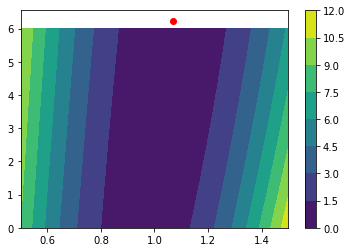

0.17564782347475372


In [105]:
 #Visualisation of the optimal parameters
beta = np.linspace(0.5, 1.5, 50)
alpha = np.linspace(0, 6, 50)
xx, yy = np.meshgrid(beta, alpha)
row=0
col=0
zz=np.ones((alpha.shape[0], beta.shape[0]))
for a in alpha:
    for b in beta:
        zz[row,col]=Q_2([b,a])
        col+=1
    col=0 
    row+=1
plt.figure()
h = plt.contourf(xx, yy, zz) 
plt.plot(Theta_hat_2[0], Theta_hat_2[1], 'ro') 
#plt.axis('scaled')
plt.colorbar()
plt.show()
 # plt.close()
print(np.min(zz))